# Optimization basics
In this notebook we demonstrate how to setup an image segmentation workflow and optimize its parameters with a given sparse annotation.

See also:
* [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index)
* [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)

In [1]:
from skimage.io import imread
from scipy.optimize import minimize
import numpy as np
import pyclesperanto_prototype as cle

We start with loading an example image and a manual annotation. Not all objects must be annotated (sparse annotation).

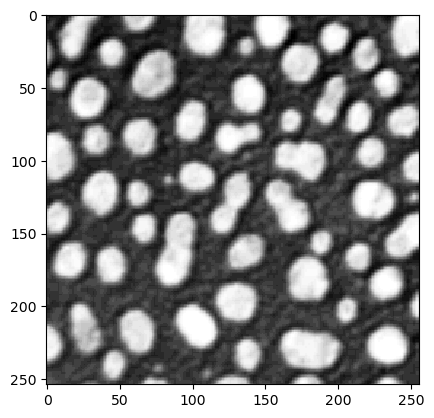

In [2]:
blobs = imread('../../data/blobs.tif')

cle.imshow(blobs)

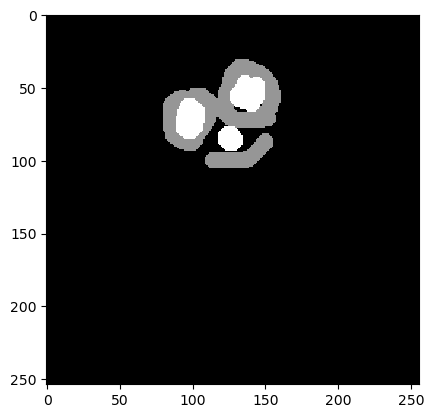

In [3]:
annotation = imread('../../data/blobs_annotated.tif')

cle.imshow(annotation)

Next, we define an image processing workflow that results in a binary image.

In [4]:
def workflow(image, sigma, threshold):
    blurred = cle.gaussian_blur(image, sigma_x=sigma, sigma_y=sigma)
    binary = cle.greater_constant(blurred, constant=threshold)
    return binary

We also test this workflow with some random `sigma` and `threshold`.

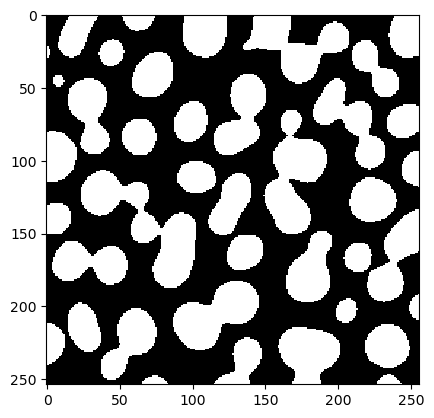

In [5]:
test = workflow(blobs, 5, 100)
cle.imshow(test)

Our [fitness function](https://en.wikipedia.org/wiki/Fitness_function) takes two parameters: A given segmentation result (test) and a reference annotation. It then determines how good the segmentation is, e.g. using the Jaccard index.

In [6]:
binary_and = cle.binary_and

def fitness(test, reference):
    """
    Determine how correct a given test segmentation is. 
    As metric we use the Jaccard index.
    Assumtion: test is a binary image(0=False and 1=True) and 
    reference is an image with 0=unknown, 1=False, 2=True.
    """
    negative_reference = reference == 1
    positive_reference = reference == 2
    negative_test = test == 0
    positive_test = test == 1
    
    # true positive: test = 1, ref = 2
    tp = binary_and(positive_reference, positive_test).sum()
    
    # true negative: 
    tn = binary_and(negative_reference, negative_test).sum()
    
    # false positive
    fp = binary_and(negative_reference, positive_test).sum()

    # false negative
    fn = binary_and(positive_reference, negative_test).sum()
    
    # return Jaccard Index
    return tp / (tp + fn + fp)

fitness(test, annotation)

0.74251497

We should also test this function on a range of parameters.

In [7]:
sigma = 5
for threshold in range(70, 180, 10):
    test = workflow(blobs, sigma, threshold)
    print(threshold, fitness(test, annotation))

70 0.49048626
80 0.5843038
90 0.67019403
100 0.74251497
110 0.8183873
120 0.8378158
130 0.79089373
140 0.7024014
150 0.60603446
160 0.49827588
170 0.3974138


Next we define a `fun`ction that takes only numerical parameters that should be optimized.

In [8]:
def fun(x):
    # apply current parameter setting
    test = workflow(blobs, x[0], x[1])
    # as we are minimizing, we multiply fitness with -1
    return -fitness(test, annotation)

Before starting the optimization, the final step is to configure the starting point `x0` for the optimization and the stoppigin criterion `atol`, the absolut tolerance value.

In [9]:
# starting point in parameter space
x0 = np.array([5, 100])

# run the optimization
result = minimize(fun, x0, method='nelder-mead', options={'xatol': 1e-3})
result

 final_simplex: (array([[  3.89501953, 121.94091797],
       [  3.89498663, 121.9409585 ],
       [  3.89500463, 121.9403702 ]]), array([-0.85761315, -0.85761315, -0.85761315]))
           fun: -0.8576131463050842
       message: 'Optimization terminated successfully.'
          nfev: 65
           nit: 22
        status: 0
       success: True
             x: array([  3.89501953, 121.94091797])

From this `result` object we can read out the parameter set that has been determined as optimal and produce a binary image.

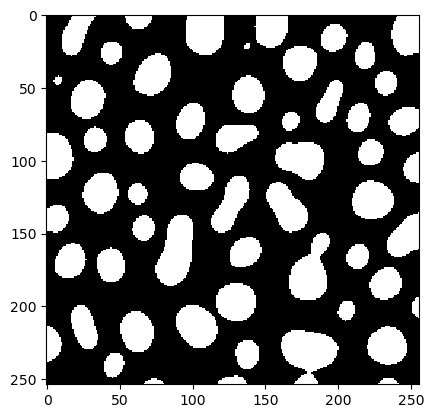

In [10]:
x = result['x']
best_binary = workflow(blobs, x[0], x[1])
cle.imshow(best_binary)

## A note on convergence

Optimization algorithms may not always find the global optimum. Succeeding depends on the starting point of the optimzation, of the shape of the parameter space and the chosen algorithm. In the following example we demonstrate how a failed optimization can look like if the starting point was chosen poorly.

In [11]:
# starting point in parameter space
x0 = np.array([0, 60])

# run the optimization
result = minimize(fun, x0, method='nelder-mead', options={'xatol': 1e-3})
result

 final_simplex: (array([[0.00000000e+00, 6.00000000e+01],
       [6.10351563e-08, 6.00000000e+01],
       [0.00000000e+00, 6.00007324e+01]]), array([-0.63195992, -0.63195992, -0.63195992]))
           fun: -0.6319599151611328
       message: 'Optimization terminated successfully.'
          nfev: 51
           nit: 13
        status: 0
       success: True
             x: array([ 0., 60.])

## Troubleshooting: Exploring the parameter space
In this case, the resulting set of parameters is not different from the starting point. In case the fitness does not change around in the starting point, the optimization algorithm does not know how to improve the result. Visualizing the values around the starting point may help.

In [12]:
sigma = 0
for threshold in range(57, 63):
    test = workflow(blobs, sigma, threshold)
    print(threshold, fitness(test, annotation))

57 0.6319599
58 0.6319599
59 0.6319599
60 0.6319599
61 0.6319599
62 0.6319599


In [13]:
threshold = 60
for sigma in np.arange(0, 0.5, 0.1):
    test = workflow(blobs, sigma, threshold)
    print(sigma, fitness(test, annotation))

0.0 0.6319599
0.1 0.6319599
0.2 0.6319599
0.30000000000000004 0.6319599
0.4 0.6319599


Thus, some manual exploration of the parameter space before running automatic optimization make sense.